In [10]:
from collections import defaultdict, Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sn
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
main_df_sampled = pd.read_pickle('main_df_sampled.pickle')
main_df_sampled

,id,subreddit,title,selftext,genre
0,4ra2z6,Throwers,new to this (vibrations),"""i recently got back into yoyos last time i ha...",hobby
1,6dkhwl,weddingplanning,vendor and photographer issues and frustrations,"""your stories and advice are most certainly we...",sex/relationships
2,5jzfbj,redditdev,[praw 360] test if comment is top level ? or ...,"""i mod a sub that is looking into adding a rul...",meta
3,6680x8,csshelp,in /r/modern_hp_theme (a test subreddit) how c...,"""/r/modern_hp_theme space:nowrap;color:#666...",programming
4,4tadox,StrangerThings,mr wheeler stole every scene he was in,"""""""what did i do ? what did iiiiiiiii doooooo...",tv_show
...,...,...,...,...,...
116995,6cum56,LearnJapanese,i'm having trouble reading the number 七十一万四千 w...,what throws me off is the 七十一 at the beginning...,education
116996,6dud8e,HotPeppers,my reaper seeds won't sprout,i'm using the damp towel in plastic bag method...,food/drink
116997,4nyacs,Warmachine,what happened to skorne ?,"""so i have no idea what happened to other fact...",board_game
116998,66y8wp,TalesFromThePizzaGuy,"""""""ma'am i know you're lying right now enjoy y...","""last week we were stupid slow all day and thi...",writing/stories


In [12]:
genres = sorted(main_df_sampled['genre'].unique().tolist()) # this has to be sorted to match up with lstm model

print('Number of genres:', len(genres))

Number of genres: 39


In [13]:
# Get frequencies of each subreddit using efficient pandas filtering.
frequencies = defaultdict(int)
for genre in genres:
    frequencies[genre] = len(main_df_sampled.loc[main_df_sampled['genre'] == genre])

frequencies_df = pd.DataFrame([frequencies])
frequencies_df = frequencies_df.T

print(scipy.stats.describe(list(frequencies.values())))
print(frequencies_df)

DescribeResult(nobs=39, minmax=(3000, 3000), mean=3000.0, variance=0.0, skewness=nan, kurtosis=nan)
                          0
advice/question        3000
animals                3000
anime/manga            3000
appearance             3000
arts                   3000
autos                  3000
board_game             3000
books                  3000
card_game              3000
company/website        3000
crypto                 3000
drugs                  3000
education              3000
electronics            3000
finance/money          3000
food/drink             3000
geo                    3000
hardware/tools         3000
health                 3000
hobby                  3000
meta                   3000
movies                 3000
music                  3000
other                  3000
parenting              3000
politics/viewpoint     3000
profession             3000
programming            3000
religion/supernatural  3000
rpg                    3000
sex/relationships      3000
soci

<ipython-input-13-d6794b4f31c7>:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(scipy.stats.describe(list(frequencies.values())))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1405: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1406: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


In [14]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
#Loading the data
import pickle

X_bert_scaled = []

with open('bert_embeddings.pickle', 'rb') as f:
  embed = pickle.load(f)

for i in range(len(main_df_sampled)):
    title = main_df_sampled['title'][i]
    selftext = main_df_sampled['selftext'][i]
    text = title + " " + selftext
    X_bert_scaled.append(embed[text])

In [16]:
X_bert_scaled = np.array(X_bert_scaled)
X_bert_scaled.shape

(117000, 768)

In [17]:
from sklearn.preprocessing import LabelEncoder

y = main_df_sampled['genre'].copy()

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Genre Mapping:")
print(genre_mapping)

Genre Mapping:
{'advice/question': 0, 'animals': 1, 'anime/manga': 2, 'appearance': 3, 'arts': 4, 'autos': 5, 'board_game': 6, 'books': 7, 'card_game': 8, 'company/website': 9, 'crypto': 10, 'drugs': 11, 'education': 12, 'electronics': 13, 'finance/money': 14, 'food/drink': 15, 'geo': 16, 'hardware/tools': 17, 'health': 18, 'hobby': 19, 'meta': 20, 'movies': 21, 'music': 22, 'other': 23, 'parenting': 24, 'politics/viewpoint': 25, 'profession': 26, 'programming': 27, 'religion/supernatural': 28, 'rpg': 29, 'sex/relationships': 30, 'social_group': 31, 'software': 32, 'sports': 33, 'stem': 34, 'travel': 35, 'tv_show': 36, 'video_game': 37, 'writing/stories': 38}


In [18]:
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert_scaled, y, test_size=0.2, random_state=42)
print(X_bert_train.shape, X_bert_test.shape, y_bert_train.shape, y_bert_test.shape)


(93600, 768) (23400, 768) (93600,) (23400,)


In [19]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [20]:
# Reshape data for LSTM input
X_bert_train = X_bert_train.reshape((X_bert_train.shape[0], 1, X_bert_train.shape[1]))
X_bert_test = X_bert_test.reshape((X_bert_test.shape[0], 1, X_bert_test.shape[1]))

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [22]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_bert_train.shape[2]), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(X_bert_train, y_bert_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
2340/2340 [==============================] - 24s 9ms/step - loss: 2.0887 - accuracy: 0.4445 - val_loss: 1.7949 - val_accuracy: 0.5007
Epoch 2/10
2340/2340 [==============================] - 18s 8ms/step - loss: 1.7090 - accuracy: 0.5194 - val_loss: 1.7223 - val_accuracy: 0.5171
Epoch 3/10
2340/2340 [==============================] - 20s 8ms/step - loss: 1.5903 - accuracy: 0.5467 - val_loss: 1.6782 - val_accuracy: 0.5310
Epoch 4/10
2340/2340 [==============================] - 18s 8ms/step - loss: 1.5088 - accuracy: 0.5688 - val_loss: 1.6637 - val_accuracy: 0.5337
Epoch 5/10
2340/2340 [==============================] - 18s 8ms/step - loss: 1.4381 - accuracy: 0.5848 - val_loss: 1.6591 - val_accuracy: 0.5365
Epoch 6/10
2340/2340 [==============================] - 16s 7ms/step - loss: 1.3812 - accuracy: 0.6012 - val_loss: 1.6634 - val_accuracy: 0.5373
Epoch 7/10
2340/2340 [==============================] - 18s 8ms/step - loss: 1.3296 - accuracy: 0.6121 - val_loss: 1.6644 - val_ac

In [24]:
# Evaluate the model
results = model.evaluate(X_bert_test, y_bert_test)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

732/732 [==============================] - 3s 3ms/step - loss: 1.7174 - accuracy: 0.5351
Test Loss: 1.7173856496810913, Test Accuracy: 0.5350854992866516


In [25]:

# Predict and generate metrics
y_pred = model.predict(X_bert_test)
y_pred = np.argmax(y_pred, axis=1)

732/732 [==============================] - 3s 3ms/step


In [34]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, cmap='Reds')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

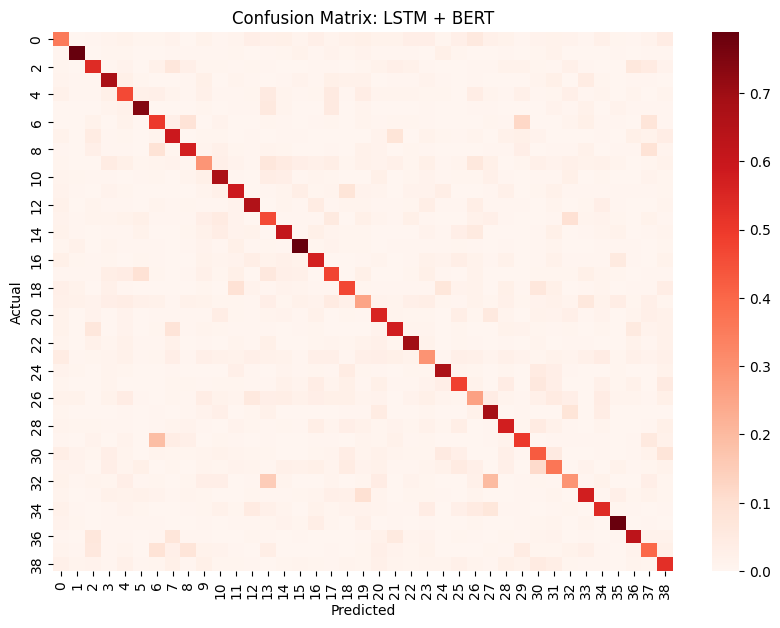

In [35]:
plot_confusion_matrix(y_bert_test, y_pred, normalize=True, title = "Confusion Matrix: LSTM + BERT")

In [36]:
print(classification_report(y_bert_test, y_pred))


              precision    recall  f1-score   support

           0       0.41      0.35      0.38       620
           1       0.80      0.79      0.79       604
           2       0.55      0.54      0.55       621
           3       0.61      0.68      0.64       598
           4       0.47      0.46      0.47       584
           5       0.71      0.74      0.73       607
           6       0.45      0.50      0.47       575
           7       0.53      0.59      0.56       589
           8       0.61      0.57      0.59       612
           9       0.37      0.29      0.32       605
          10       0.60      0.67      0.63       608
          11       0.55      0.59      0.57       545
          12       0.64      0.66      0.65       609
          13       0.37      0.46      0.41       591
          14       0.58      0.61      0.59       579
          15       0.72      0.79      0.76       641
          16       0.55      0.57      0.56       628
          17       0.45    